In [ ]:
import json
# import ast

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics
# from transformers import AutoTokenizer
# import torch
import shap

from pandarallel import pandarallel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
from Levenshtein import distance as lev_distance

import os
from tqdm import tqdm
import random
from collections import Counter
import pickle
import warnings

from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)
InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last

In [ ]:
data = pd.read_csv("../data/raw/train_dataset_Самолет.csv")

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
seed_everything()

# Feature Engineering 

In [ ]:
def create_features(data):
    data['day'] = pd.to_datetime(data['report_date']).dt.day
    data['week'] = pd.to_datetime(data['report_date']).dt.week
    data['weekday'] = pd.to_datetime(data['report_date']).dt.weekday
    data['month'] = pd.to_datetime(data['report_date']).dt.month
    data['year'] = pd.to_datetime(data['report_date']).dt.year
    return data

In [ ]:
data = create_features(data)

In [ ]:
categorical_columns = data.select_dtypes(exclude=['float64', 'int64']).columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [ ]:
X = data.drop(columns=['target'])
Y = data['target']

In [ ]:
X = X.iloc[:, np.where(~X.dtypes.isin(['float64', 'int64']))[0]].astype('str')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.33, random_state=42, shuffle=True)

# Model

In [ ]:
def catboost_model_classifier(x_train, x_test, y_train, y_test):

    # categorical_features_indices = np.where(x_train.dtypes != np.float)[0]
    categorical_features_indices = np.where(~X_train.dtypes.isin(['float64', 'int64']))[0]  # X_train.select_dtypes('category').columns.to_list()

    cb_model = CatBoostClassifier(
        # custom_loss=metrics.Accuracy(),
        loss_function='Logloss',
        random_seed=42,
        logging_level='Silent',
        # custom_metric=['MAE', 'MAPE'],
        max_depth=8,
        iterations=200,
        # scale_pos_weight=26,
        auto_class_weights='Balanced',
        # eval_metric=[metrics.Precision(), metrics.Recall(), metrics.F1(), metrics.TotalF1(), metrics.Accuracy()]
    )

    cb_model.fit(
        x_train, y_train,
        eval_set=(x_test, y_test),
        cat_features=categorical_features_indices,
        plot=True
    )

    return cb_model


In [ ]:
model = catboost_model_classifier(X_train, X_test, y_train, y_test)

In [ ]:
y_pred = model.predict(X_valid)

In [ ]:
roc_auc_score(y_valid, y_pred)

# Feature Selection

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

In [59]:
perm = (
    pd.DataFrame(columns=['AVG_Importance', 'STD_Importance'], index=[i for i in X_train.columns])
    .assign(AVG_Importance=result.importances_mean)
    .assign(STD_Importance=np.std(result.importances, axis=1))
    .sort_values(by='AVG_Importance', ascending=False)
)

<Axes: ylabel='AVG_Importance'>

([], [])

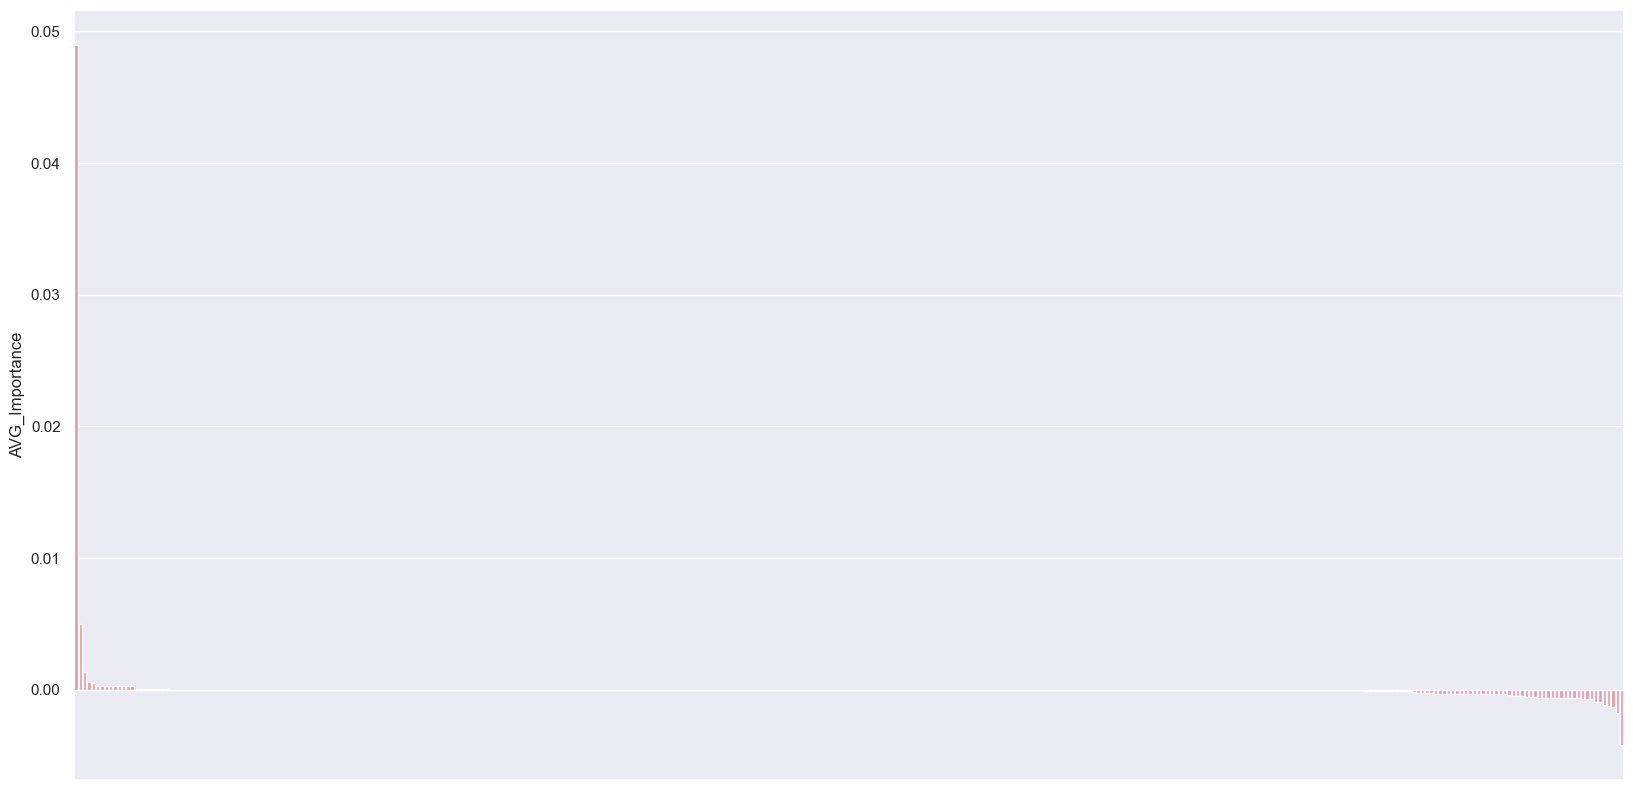

In [60]:
sns.barplot(x=perm.index, y=perm.AVG_Importance)
plt.xticks([])
plt.show()

# Hyperparameters Tuning

# Validation